### Table of contents
1. [Create CAS Connection](#casConnection)
2. [Load Data and Prep](#dataLoadPrep)
3. [Explore Data](#exploreData)
4. [Begin Modeling](#beginModel)
  - [Transformation, Weight of Evidence, & Information Value](#woe)
  - [Logistic Regression](#lr)
  - [Score Card](#scorecard)
5. [Visualizations](#visual)
6. [Scoring New Data](#score)

In [1]:
# Import Libraries
import swat
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

### Create a Connection to CAS and Set Library <a name="casConnection"></a>

In [2]:
# Create CAS Connection
conn = swat.CAS(host, portnum, user, password)

In [3]:
# Setup a CAS Library
conn.addcaslib(activeonadd=True,
                     datasource={'srctype':'path'},
                     name='bankDataLib',
                     path='/data/andre_data/bankDataLib',
                     subdirectories=True);

NOTE: 'bankDataLib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'bankDataLib'.


### Load Bank Data to CAS and Prep <a name="dataLoadPrep"></a>

In [4]:
# Load Data
data = pd.read_csv('/data/andre_data/bankDataLib/cs_accepts_train_small.csv')

In [5]:
# Shape
data.shape

(156915, 27)

In [6]:
# Impute Median for Missing Values
data['TimeAddress'] = data['TimeAddress'].fillna((data['TimeAddress'].median()))
data['TimeJob'] = data['TimeJob'].fillna((data['TimeJob'].median()))

In [7]:
# Preview Data
pd.set_option('display.max_columns', 500)
data.head()

,_customerID,target,title,Nchildren,Nhousehold,Age,TimeAddress,TimeJob,tel,NumMyLoan,NumFinLoan,NumLoans,Income,EC_Card,IncLevel,status,bureau,region,regionLarge,cash,product,resid,nat,prof,car,card,saving
0,c000000028,Bad,H,1,2,26,9.0,27.0,1,0,1,3,10000,0,2,U,1,4,1,2500,Furniture,Lease,German,G,Car,No,Yes
1,c000000032,Bad,H,0,1,34,42.0,39.0,1,0,1,1,2400,0,1,U,1,7,1,3000,Electronics,Lease,German,NaN,Car,No,No
2,c000000040,Good,R,0,2,35,72.0,18.0,2,0,0,0,0,1,0,V,3,0,0,1500,Dept. Store,Lease,German,NaN,Without Vehicle,Yes,No
3,c000000051,Good,H,3,5,34,48.0,60.0,1,0,1,1,0,1,0,V,1,7,1,700,Dept. Store,Owner,German,C,Car,Yes,No
4,c000000065,Good,R,0,1,22,216.0,45.0,2,0,0,0,0,1,0,U,1,4,1,3000,Furniture,Lease,German,NaN,Car,Yes,Yes


In [8]:
# Write Out Dataframe to CAS
data = conn.upload_frame(data, casout=dict(name='data', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table DATA in caslib bankDataLib.
NOTE: The table DATA has been created in caslib bankDataLib from binary data uploaded to Cloud Analytic Services.


In [9]:
conn.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,ModTime,AccessTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,DATA,156915,27,0,utf-8,2018-11-28T19:51:28+00:00,2018-11-28T19:51:28+00:00,2018-11-28T19:51:28+00:00,UTF8,1.859054e+09,1.859054e+09,1.859054e+09,0,0,0,,,0,sas,,2018-11-28T19:51:28+00:00,1.859054e+09


### Explore Data <a name="exploreData"></a>

In [10]:
# View Target Variable Balance
data['target'].freq()

,Column,CharVar,FmtVar,Level,Frequency
0,target,Bad,Bad,1,31704.0
1,target,Good,Good,2,125211.0


In [11]:
# Numeric Variables Summary
conn.CASTable('data').describe()

,Nchildren,Nhousehold,Age,TimeAddress,TimeJob,tel,NumMyLoan,NumFinLoan,NumLoans,Income,EC_Card,IncLevel,bureau,region,regionLarge,cash
count,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.000000,156915.00000,156915.000000,156915.000000,156915.000000,156915.000000
mean,0.880878,2.483765,35.937559,92.282038,78.329280,1.354077,0.594908,0.495357,0.930211,1956.248287,0.319179,1.01778,1.741045,3.276016,0.733429,2310.432400
std,1.052363,1.343317,11.301323,87.014462,82.825167,0.478234,0.886872,0.499980,1.071630,1586.337523,0.466160,0.77323,0.965084,2.542618,0.442168,2673.116409
min,0.000000,1.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,27.000000,24.000000,21.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,1000.000000
50%,1.000000,2.000000,34.000000,60.000000,45.000000,1.000000,0.000000,0.000000,1.000000,2100.000000,0.000000,1.00000,1.000000,3.000000,1.000000,1500.000000
75%,2.000000,3.000000,43.000000,144.000000,108.000000,2.000000,2.000000,1.000000,1.000000,2800.000000,1.000000,2.00000,3.000000,5.000000,1.000000,2500.000000
max,6.000000,8.000000,72.000000,384.000000,360.000000,2.000000,2.000000,1.000000,9.000000,10000.000000,1.000000,2.00000,3.000000,9.000000,1.000000,20000.000000


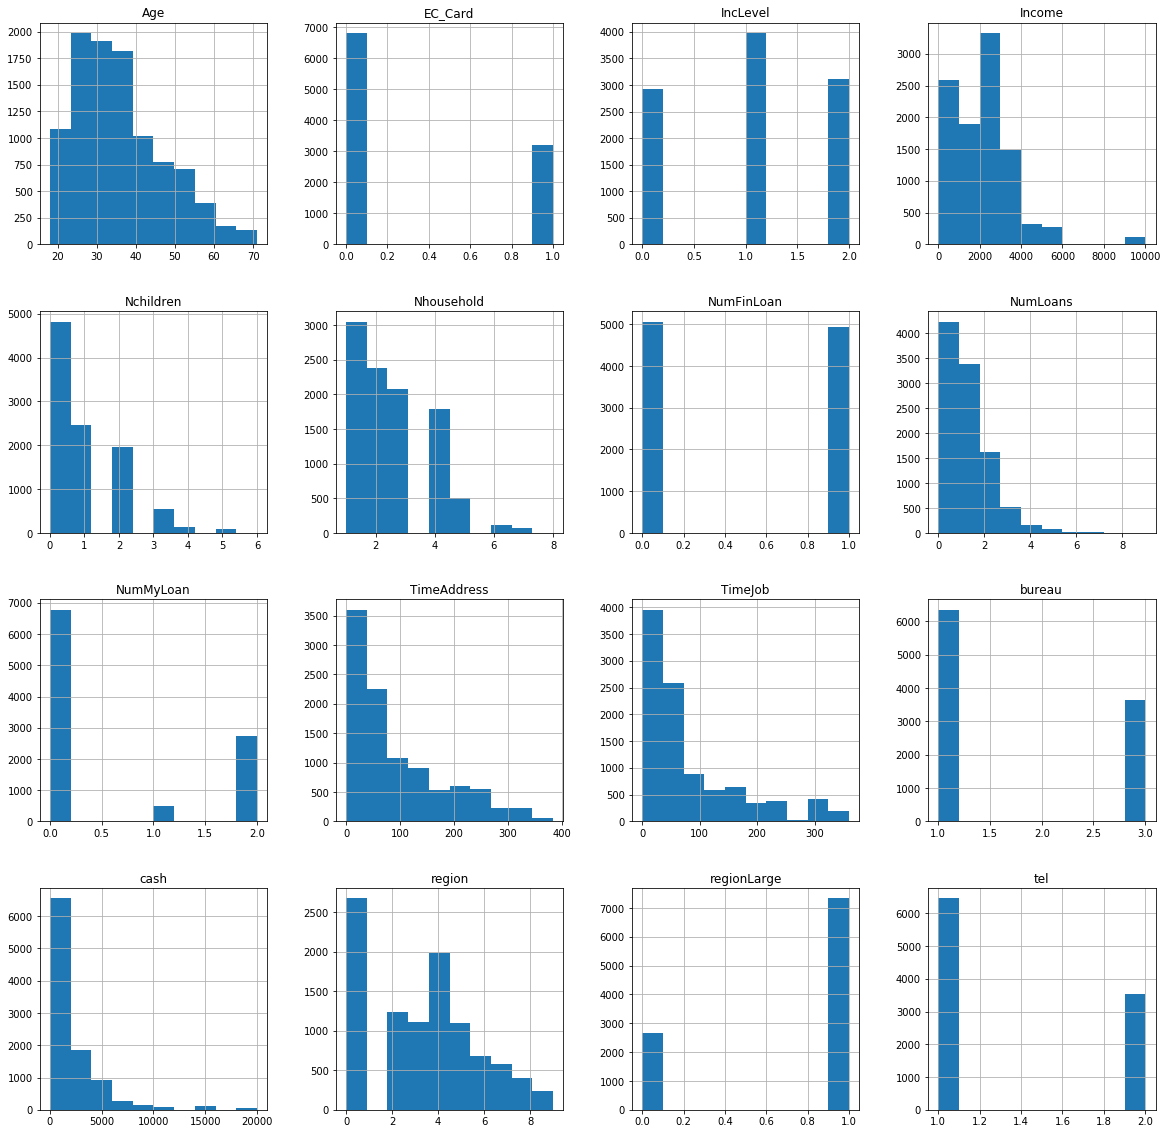

In [12]:
# Visualize Numeric Variable Distributions
data.hist(figsize = (20, 20));

### Begin Modeling <a name="beginModel"></a>

<a name="woe"></a>

<div class="alert alert-info">
<b>Transformations, Weight of Evidence, & Information Value</b>
</div>

In [13]:
# Load Regression Action Set
conn.loadactionset(actionset='regression')
conn.loadactionset(actionset='dataPreprocess');

NOTE: Added action set 'regression'.
NOTE: Added action set 'dataPreprocess'.


In [14]:
# Set Up Inputs and Target
nominal_inputs = ['title', 'status', 'product', 'resid', 'nat', 'prof', 'car', 'card', 'saving']
cont_inputs = ['Nchildren', 'Nhousehold', 'Age', 'TimeAddress', 'TimeJob', 'tel', 'NumMyLoan', 'NumFinLoan',
               'NumLoans', 'Income', 'EC_Card', 'IncLevel', 'bureau', 'region', 'regionLarge', 'cash']
target = 'target'

#### Set up Weight of Evidence Transform

In [15]:
# Transform Pipeline
req_packs = []

req_pack1 = dict(name='req_intervals',
                inputs=cont_inputs,
                targets=target,
                events='Bad',
                discretize=dict(method='woe',
                                args = dict(minNBins=3, maxNBins=7)),
                output=dict(scoreWOE=True))

req_pack2 = dict(name='req_nominals',
                inputs=nominal_inputs,
                targets=target,
                events='Bad',
                cattrans=dict(method='woe',
                                args = dict(minNBins=3, maxNBins=7)),
                output=dict(scoreWOE=True))

req_packs.append(req_pack1)
req_packs.append(req_pack2)

In [16]:
# Transform
woeTransform = conn.transform(table=data,
                              requestPackages=req_packs, 
                              casOut=dict(name='woeTransform', replace=True),
                              code = dict(casout=dict(name='woe_code', replace=True)),
                              copyVars = ['target', '_customerID'],
                              outVarsNameGlobalPrefix='woe');

In [17]:
# preview Weights Table
conn.CASTable('woeTransform').head(n=5)

,target,_customerID,woe_Age,woe_bureau,woe_cash,woe_EC_Card,woe_IncLevel,woe_Income,woe_Nchildren,woe_Nhousehold,woe_NumFinLoan,woe_NumLoans,woe_NumMyLoan,woe_region,woe_regionLarge,woe_tel,woe_TimeAddress,woe_TimeJob,woe_car,woe_card,woe_nat,woe_product,woe_prof,woe_resid,woe_saving,woe_status,woe_title
0,Bad,c001432245,-0.595045,-0.038464,-0.342228,-0.214584,0.164962,0.260577,0.278284,0.305091,0.125904,-0.034920,-0.081022,-0.106657,-0.052918,-0.116763,-0.020547,-0.080789,0.106343,-0.260065,-0.018781,0.194776,-0.119681,NaN,0.009154,0.390124,-0.033008
1,Good,c001432250,0.864306,0.089431,0.085037,-0.214584,-0.432184,-0.238071,-0.223703,-0.536068,-0.115021,0.049761,-0.081022,0.155021,0.155021,0.067595,-0.100103,0.020216,-0.388738,-0.260065,-0.018781,0.067617,0.485818,0.163690,-0.007078,0.041665,0.085426
2,Good,c001432251,0.864306,-0.038464,0.150900,-0.214584,-0.432184,-0.238071,-0.223703,0.333864,-0.115021,0.034676,-0.081022,0.155021,0.155021,-0.116763,0.316728,1.145976,-0.388738,-0.260065,-0.018781,0.194776,NaN,-0.022113,0.009154,0.390124,0.085426
3,Good,c001432257,0.002943,-0.038464,0.451330,-0.214584,0.164962,-0.027397,-0.223703,0.333864,0.125904,0.034676,0.302566,-0.106657,-0.052918,0.067595,-0.020547,0.358676,0.106343,-0.260065,-0.018781,0.194776,NaN,NaN,NaN,0.390124,-0.033008
4,Good,c001432264,1.314781,-0.038464,-0.342228,-0.214584,-0.432184,-0.238071,-0.223703,0.333864,-0.115021,0.049761,-0.081022,0.155021,0.155021,-0.116763,-0.100103,-0.583998,0.106343,-0.260065,-0.018781,-0.178065,0.485818,-0.022113,-0.007078,0.390124,-0.033008


#### View Information Values and Predictive Power of Features

In [18]:
# Information Value (IV) to Determine Predictive Features
var_info_df = pd.DataFrame(woeTransform['VarTransInfo'])
var_info_df.sort_values(by=['IV'], ascending=True, inplace=True)

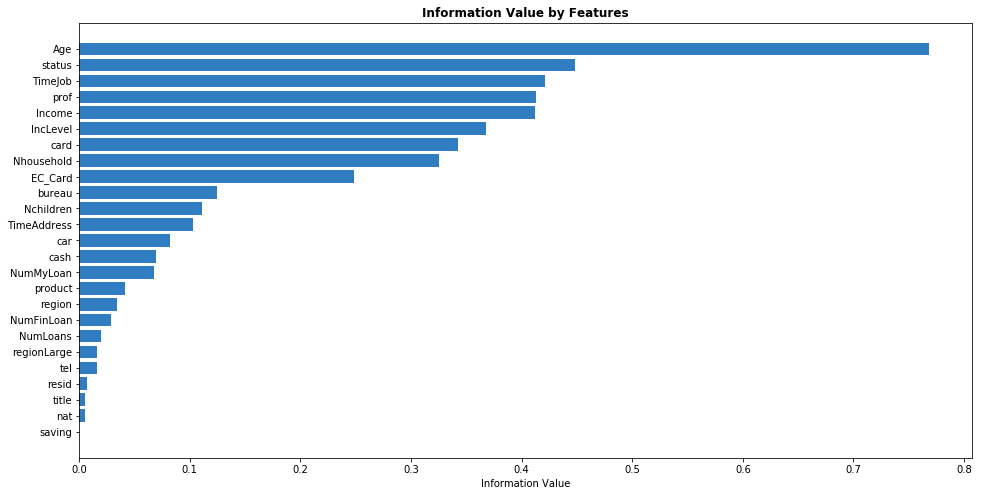

In [19]:
# Plot IV
plt.figure(figsize=(16,8))
plt.barh(var_info_df['Variable'], var_info_df['IV'], color = '#317DC2')
plt.xlabel('Information Value')
plt.title('Information Value by Features', fontweight="bold");

#### View WOE Values by Bin for Several Features

In [20]:
# Write Out CAS Table to Pandas Dataframe
woeTransform_df = conn.fetch(table='woeTransform', maxrows=len(data), to=len(data))
woeTransform_df = pd.DataFrame(woeTransform_df['Fetch'])

In [21]:
# Convert Bin Details to Pandas DF for Plotting
woe_bin_df = pd.DataFrame(woeTransform['BinDetails'])

# Time on Job DF
woe_bin_toj = woe_bin_df[woe_bin_df['Variable']=='TimeJob']
woe_bin_age = woe_bin_df[woe_bin_df['Variable']=='Age']
woe_bin_cash = woe_bin_df[woe_bin_df['Variable']=='cash']
woe_bin_prof = woe_bin_df[woe_bin_df['Variable']=='prof']

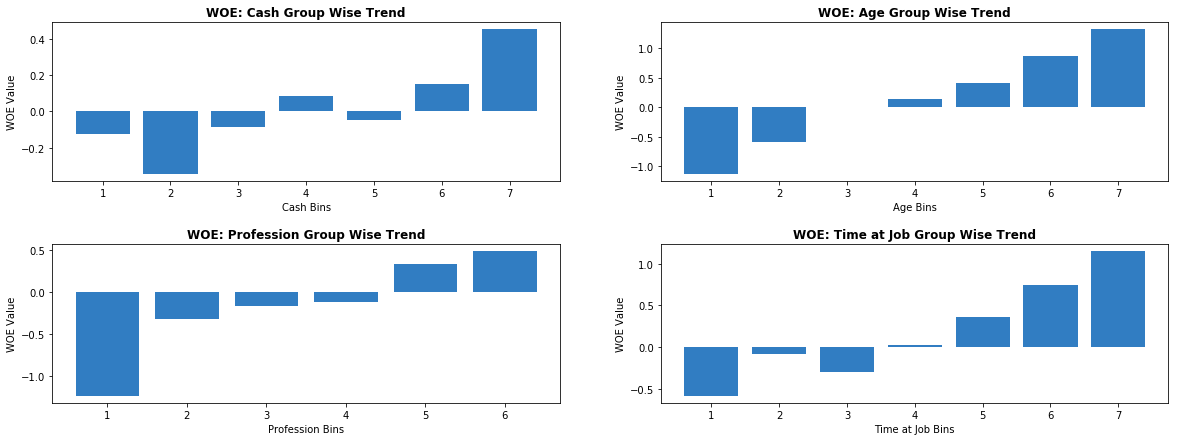

In [24]:
# Plot Examples -  WoE value is a measure of the "strength” of a grouping for separating good and bad credit
plt.figure(figsize=(20,7))
plt.subplots_adjust(hspace=.4)

plt.subplot(2, 2, 1)
plt.bar(woe_bin_cash['BinId'], woe_bin_cash['WOE'], color = '#317DC2')
plt.title('WOE: Cash Group Wise Trend', fontweight="bold")
plt.xlabel('Cash Bins')
plt.ylabel('WOE Value')

plt.subplot(2, 2, 2)
plt.bar(woe_bin_age['BinId'], woe_bin_age['WOE'], color = '#317DC2')
plt.title('WOE: Age Group Wise Trend', fontweight="bold")
plt.xlabel('Age Bins')
plt.ylabel('WOE Value')

plt.subplot(2, 2, 3)
plt.bar(woe_bin_prof['BinId'], woe_bin_prof['WOE'], color = '#317DC2')
plt.title('WOE: Profession Group Wise Trend', fontweight="bold")
plt.xlabel('Profession Bins')
plt.ylabel('WOE Value')

plt.subplot(2, 2, 4)
plt.bar(woe_bin_toj['BinId'], woe_bin_toj['WOE'], color = '#317DC2')
plt.title('WOE: Time at Job Group Wise Trend', fontweight="bold")
plt.xlabel('Time at Job Bins')
plt.ylabel('WOE Value');

<a name="lr"></a>

<div class="alert alert-info">
<b>Logistic Regression</b>
</div>

In [25]:
# Set Empty CAS Table For Model Results
lr_woe_model = conn.CASTable("lr_woe_model",replace = True)

In [26]:
# Concat 'woe_' with Column Names for Inputs
woe_inputs = ['woe_' + str(col)  for col in data.columns[2:]]

lr_woe_model = conn.logistic(table = 'woeTransform',
                             model = dict(depvar=[dict(name=target,
                                                       options=dict(ref='Good'))],
                                          effects=woe_inputs),
                             selection = dict(method='FORWARD'),
                             store = dict(name='my_lr_Model', replace=True),
                             code = dict(casout=dict(name='lr_code', replace=True)),
                             output = dict(casOut=dict(name='lr_woe_model', replace=True),
                                           copyVars=['target', '_customerID'], predprobs=True))

NOTE: Convergence criterion (GCONV=1E-8) satisfied.


<a name="scorecard"></a>

<div class="alert alert-info">
<b>Scorecard</b>
</div>

In [27]:
# Parameter Table from Logistic Regression
lr_woe_mod_params = pd.DataFrame(lr_woe_model['SelectedModel.ParameterEstimates'])
lr_woe_mod_params = lr_woe_mod_params[['Parameter','Estimate']]

# Intercept
intercept = lr_woe_mod_params['Estimate'][0]

# Drop Intercept
lr_woe_mod_params = lr_woe_mod_params[lr_woe_mod_params['Parameter'] != 'Intercept']

In [28]:
# Fill NA Values with Zero
woeTransform_df = woeTransform_df.fillna(0)

In [29]:
woeTransform_df.head()

,target,_customerID,woe_Age,woe_bureau,woe_cash,woe_EC_Card,woe_IncLevel,woe_Income,woe_Nchildren,woe_Nhousehold,woe_NumFinLoan,woe_NumLoans,woe_NumMyLoan,woe_region,woe_regionLarge,woe_tel,woe_TimeAddress,woe_TimeJob,woe_car,woe_card,woe_nat,woe_product,woe_prof,woe_resid,woe_saving,woe_status,woe_title
0,Bad,c001432245,-0.595045,-0.038464,-0.342228,-0.214584,0.164962,0.260577,0.278284,0.305091,0.125904,-0.034920,-0.081022,-0.106657,-0.052918,-0.116763,-0.020547,-0.080789,0.106343,-0.260065,-0.018781,0.194776,-0.119681,0.000000,0.009154,0.390124,-0.033008
1,Good,c001432250,0.864306,0.089431,0.085037,-0.214584,-0.432184,-0.238071,-0.223703,-0.536068,-0.115021,0.049761,-0.081022,0.155021,0.155021,0.067595,-0.100103,0.020216,-0.388738,-0.260065,-0.018781,0.067617,0.485818,0.163690,-0.007078,0.041665,0.085426
2,Good,c001432251,0.864306,-0.038464,0.150900,-0.214584,-0.432184,-0.238071,-0.223703,0.333864,-0.115021,0.034676,-0.081022,0.155021,0.155021,-0.116763,0.316728,1.145976,-0.388738,-0.260065,-0.018781,0.194776,0.000000,-0.022113,0.009154,0.390124,0.085426
3,Good,c001432257,0.002943,-0.038464,0.451330,-0.214584,0.164962,-0.027397,-0.223703,0.333864,0.125904,0.034676,0.302566,-0.106657,-0.052918,0.067595,-0.020547,0.358676,0.106343,-0.260065,-0.018781,0.194776,0.000000,0.000000,0.000000,0.390124,-0.033008
4,Good,c001432264,1.314781,-0.038464,-0.342228,-0.214584,-0.432184,-0.238071,-0.223703,0.333864,-0.115021,0.049761,-0.081022,0.155021,0.155021,-0.116763,-0.100103,-0.583998,0.106343,-0.260065,-0.018781,-0.178065,0.485818,-0.022113,-0.007078,0.390124,-0.033008


In [30]:
# Filter WOE Transform Table to Only Selected Features from Logistic Regression
selected_params = lr_woe_mod_params['Parameter']

woeTransform_df_selected = woeTransform_df[selected_params]

In [31]:
# Ensure Shapes are Correct for Matrix Multiplication
display(woeTransform_df_selected.shape)
display(lr_woe_mod_params.shape)

(156915, 22)

(22, 2)

In [32]:
# Set Parameter Name as Index
lr_woe_mod_params_index = lr_woe_mod_params.set_index('Parameter')

In [33]:
# Multiply lr coefficients to observation WOE Values
scorecard = woeTransform_df_selected[lr_woe_mod_params_index.index].apply(lambda x: x*lr_woe_mod_params_index['Estimate'].T,axis=1)

In [34]:
# Get Logit Values
scorecard['logit'] = scorecard[list(scorecard.columns)].sum(axis=1) + intercept

In [35]:
# Convert Logit to Odds Ratio and Odds Ratio to Probability
scorecard['odds'] = np.exp(scorecard['logit'])
scorecard['probs'] = scorecard['odds'] / (scorecard['odds'] + 1)

In [36]:
# Set up Scoring Logic
target_score = 600
target_odds = 30
pts_double_odds = 20

factor = pts_double_odds / np.log(2)
offset = target_score - factor * np.log(target_odds)

In [37]:
# Score
scorecard['score'] = offset + factor * scorecard['logit']

In [38]:
# Add Back Customer ID and Target Features
scorecard['customer_id'] = woeTransform_df['_customerID']
scorecard['target'] = woeTransform_df['target']

In [39]:
# Remove Score Outliers (245, 0.156% of Total)
scorecard = scorecard[scorecard['score'] <= 600]

In [40]:
# Preview Score Data (Scores, Odds, Probs, etc)
scorecard.head(n=5)

,woe_title,woe_Nchildren,woe_Nhousehold,woe_Age,woe_TimeAddress,woe_TimeJob,woe_tel,woe_NumMyLoan,woe_NumFinLoan,woe_NumLoans,woe_IncLevel,woe_status,woe_bureau,woe_region,woe_regionLarge,woe_cash,woe_product,woe_resid,woe_nat,woe_prof,woe_car,woe_card,logit,odds,probs,score,customer_id,target
0,-0.042035,-0.253880,0.131529,0.489121,-0.005789,0.017686,0.082845,0.064373,-0.072818,0.052446,-0.076342,-0.133144,0.089511,0.077610,-0.145221,0.172456,-0.114729,-0.000000,0.035011,0.099197,-0.147883,0.198521,-0.818096,0.441271,0.306168,478.256915,c001432245,Bad
1,0.108788,0.204085,-0.231106,-0.710451,-0.028206,-0.004426,-0.047959,0.064373,0.066524,-0.074736,0.200007,-0.014220,-0.208118,-0.112802,0.425417,-0.042852,-0.039829,-0.205486,0.035011,-0.402665,0.540589,0.198521,-1.616101,0.198672,0.165743,455.231362,c001432250,Good
2,0.108788,0.204085,0.143933,-0.710451,0.089245,-0.250877,0.082845,0.064373,0.066524,-0.052079,0.200007,-0.133144,0.089511,-0.112802,0.425417,-0.076042,-0.114729,0.027759,0.035011,-0.000000,0.540589,0.198521,-0.510076,0.600450,0.375176,487.144495,c001432251,Good
3,-0.042035,0.204085,0.143933,-0.002419,-0.005789,-0.078521,-0.047959,-0.240394,-0.072818,-0.052079,-0.076342,-0.133144,0.089511,0.077610,-0.145221,-0.227435,-0.114729,-0.000000,0.035011,-0.000000,-0.147883,0.198521,-1.974659,0.138809,0.121889,444.885563,c001432257,Good
4,-0.042035,0.204085,0.143933,-1.080737,-0.028206,0.127849,0.082845,0.064373,0.066524,-0.074736,0.200007,-0.133144,0.089511,-0.112802,0.425417,0.172456,0.104886,0.027759,0.035011,-0.402665,-0.147883,0.198521,-1.415591,0.242782,0.195354,461.016858,c001432264,Good


<a name="visual"></a>

<div class="alert alert-info">
<b>Visualizing our Scores</b>
</div>

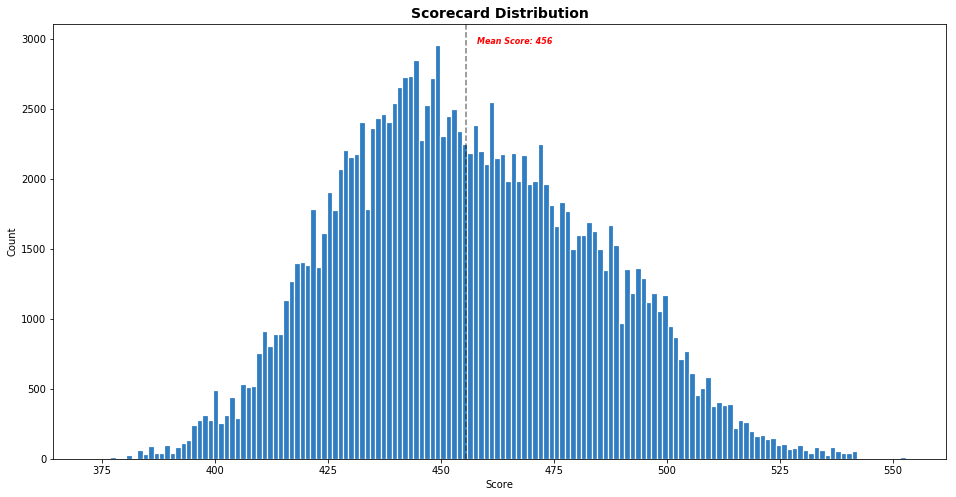

In [41]:
# Plot Distribution of Scores
plt.figure(figsize=(16,8))

plt.hist(scorecard['score'],
         bins=150,
         edgecolor='white',
         color = '#317DC2',
         linewidth=1.2)

#plt.xlim(231,750)
plt.title('Scorecard Distribution', fontweight="bold", fontsize=14)
plt.axvline(scorecard['score'].mean(), color='k', linestyle='dashed', linewidth=1.5, alpha=0.5)
plt.text(458, 2970, 'Mean Score: 456', color='red', fontweight='bold', style='italic', fontsize=8)
plt.xlabel('Score')
plt.ylabel('Count');

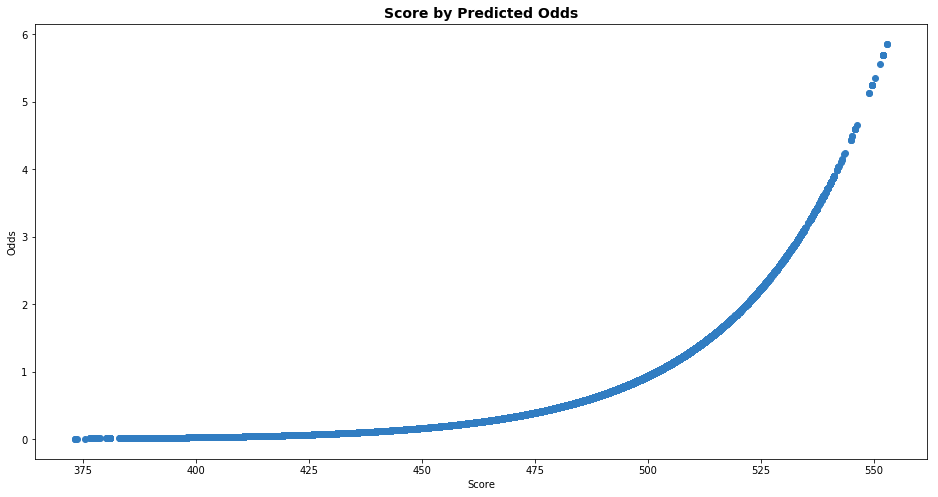

In [42]:
# Plot Scores Against Predicted Odds (Exponential Relationship)
plt.figure(figsize=(16,8))

plt.scatter(x='score',
            y='odds',
            data=scorecard,
            color='#317DC2')

plt.title('Score by Predicted Odds', fontweight="bold", fontsize=14)
plt.xlabel('Score')
plt.ylabel('Odds');

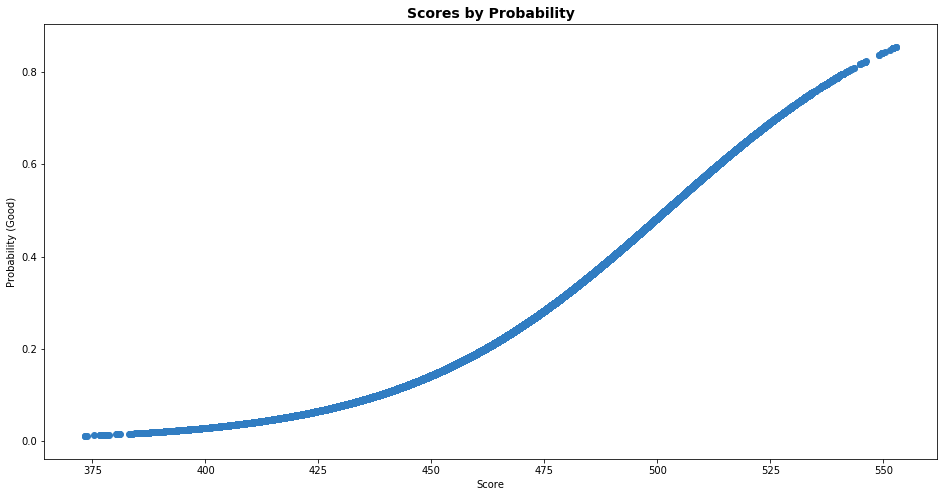

In [43]:
# Plot Scores Against Probabilities
plt.figure(figsize=(16,8))

plt.scatter(x='score',
            y='probs',
            data=scorecard,
            color='#317DC2')

plt.title('Scores by Probability', fontweight="bold", fontsize=14)
plt.xlabel('Score')
plt.ylabel('Probability (Good)');

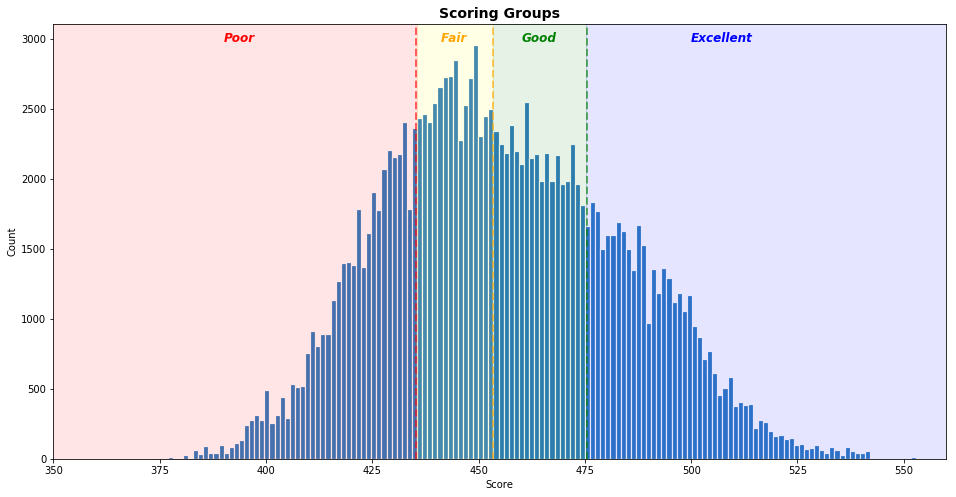

In [44]:
# Add Scoring Groups to Plot
plt.figure(figsize=(16,8))

plt.hist(scorecard['score'],
         bins=150,
         edgecolor='white',
         color = '#317DC2',
         linewidth=1.2)

plt.xlim(350,560)
plt.title('Scoring Groups', fontweight="bold", fontsize=14)
plt.xlabel('Score')
plt.ylabel('Count')

# Percentile Lines
plt.axvline(np.percentile(scorecard['score'],25), color='red', linestyle='dashed', linewidth=2, alpha=0.6)
plt.axvline(np.percentile(scorecard['score'],50), color='orange', linestyle='dashed', linewidth=2, alpha=0.6)
plt.axvline(np.percentile(scorecard['score'],75), color='green', linestyle='dashed', linewidth=2, alpha=0.6)

# Text
plt.text(390, 2980, 'Poor', color='red', fontweight='bold', style='italic', fontsize=12)
plt.text(441, 2980, 'Fair', color='orange', fontweight='bold', style='italic', fontsize=12)
plt.text(460, 2980, 'Good', color='green', fontweight='bold', style='italic', fontsize=12)
plt.text(500, 2980, 'Excellent', color='blue', fontweight='bold', style='italic', fontsize=12)

# Shading between Percentiles
plt.axvspan(350, 435.5, alpha=0.1, color='red')
plt.axvspan(435.5, 453.5, alpha=0.1, color='yellow')
plt.axvspan(453.5, 475.38, alpha=0.1, color='green')
plt.axvspan(475.38, 560, alpha=0.1, color='blue');

<a name="score"></a>

<div class="alert alert-info">
<b>Scoring New Data</b>
</div>

In [45]:
# Just take 5 Samples for Fake Test Set to Show Scoring
testData = pd.DataFrame(conn.CASTable('data').head())

In [46]:
# Load to CAS
testData = conn.upload_frame(testData, casout=dict(name='testData', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table TESTDATA in caslib bankDataLib.
NOTE: The table TESTDATA has been created in caslib bankDataLib from binary data uploaded to Cloud Analytic Services.


In [47]:
# Create Function from SAS Actions to Score From Data to WOE to Imputation to Logistic
def model_scoring(conn, woe_code_tbl, lr_code_tbl, test_tbl, scored_tbl_name):
    
    conn.datastep.runcodetable(codetable = woe_code_tbl,
                           table = test_tbl,
                           casOut = dict(name='woe_out_tbl_1'))
    
    conn.impute(table=dict(name='woe_out_tbl_1'),
                             methodInterval='VALUE',
                             valuesInterval=[0],
                             casout=dict(name='imp_out_tbl_2', replace=True),
                             outVarsNamePrefix='')
    
    conn.datastep.runcodetable(codetable = lr_code_tbl,
                           table = 'imp_out_tbl_2',
                           casOut = dict(name=scored_tbl_name))

In [48]:
# Score Data
model_scoring(conn, 'woe_code', 'lr_code', testData, 'scored_data')